## Fine tuning text simplification with BART
Use pseudo wiki parallel data to fine tune Chinese BART for TS task

### Load packages and models

In [ ]:
!pip install jieba evaluate sacrebleu sacremoses datasets

In [1]:
%load_ext autoreload
%autoreload 2
# import pandas as pd
import numpy as np
import jieba
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
from datasets import Dataset
import pickle
# from easse.sari import sentence_sari
from evaluate import load
sari = load("sari")
with open("../data/HSK/HSK_levels.pickle", 'rb') as handle:
    HSK_dict = pickle.load(handle)

In [12]:
from transformers import BertTokenizer, BartForConditionalGeneration, Text2TextGenerationPipeline, AutoModelForSeq2SeqLM
tokenizer = BertTokenizer.from_pretrained("../data/models/batch_128_15625_500000", local_files_only=True)
model = BartForConditionalGeneration.from_pretrained("../data/models/batch_128_15625_500000", local_files_only=True)
# model = AutoModelForSeq2SeqLM.from_pretrained("fnlp/bart-base-chinese")

### Load data

In [ ]:
# original mcts data
lines_orig = []
with open('../data/mcts/mcts.dev.orig', encoding="utf8") as f:
        lines_orig = f.read().splitlines()

lines_ref = []
with open('../data/mcts/mcts.dev.simp.0', encoding="utf8") as f:
        lines_ref = f.read().splitlines()

In [4]:
def tokenize_with_HSK(sentence, HSK_dict):
    split_sentence = jieba.lcut(sentence)
    HSK_sentence = ""
    for word in split_sentence:
        score = HSK_dict.get(word, 0)
        if score>3:
            HSK_sentence += f"{word}[{score}]"
        else:
            HSK_sentence += f"{word}"
    # HSK_sentence = "".join([f"{word}[{HSK_dict.get(word, 0)}]" for word in split_sentence])
    # HSK_sentence = f"[{score}]" + HSK_sentence
    return HSK_sentence

tokenizer.add_tokens(["[4]", "[5]", "[6]", "[7]"])
model.resize_token_embeddings(len(tokenizer))

def preprocess_data(filename: str, start: int, stop: int):
    lines_HSK = []
    with open(filename, encoding="utf8") as f:
        lines_orig = f.read().splitlines()
        for line in lines_orig[start:stop]:
            lines_HSK.append(tokenize_with_HSK(line, HSK_dict))
    return lines_HSK

In [6]:
start = 0
stop = 1000
split = 750

lines_complex = preprocess_data('../data/mcts-pseudo/zh_selected.ori', start, stop)
lines_simple = preprocess_data('../data/mcts-pseudo/zh_selected.sim', start, stop)

data_dict = {'complex': lines_complex[start:split], 'simple': lines_simple[start:split]}
ds_train = Dataset.from_dict(data_dict)
data_dict = {'complex': lines_complex[split:stop], 'simple': lines_simple[split:stop]}
ds_eval = Dataset.from_dict(data_dict)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\tempu\AppData\Local\Temp\jieba.cache
Loading model cost 1.889 seconds.
Prefix dict has been built successfully.


In [ ]:
# tokenize data
max_length = 128
def batch_tokenize_data(data):
    inputs = [example for example in data["complex"]]
    targets = [example for example in data["simple"]]

    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=max_length, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data_train = ds_train.map(batch_tokenize_data, batched=True)
tokenized_data_eval = ds_eval.map(batch_tokenize_data, batched=True)

### Set up trainer

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

training_args = TrainingArguments(
    output_dir="./bart_simplification",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    eval_accumulation_steps = 1,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=500
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_data_train,
    eval_dataset = tokenized_data_eval,
    tokenizer = tokenizer
)

### Train

In [ ]:
trainer.train()

### Evaluate

In [15]:
sentence = ds_train['complex'][0]

In [ ]:
# idx = 0
# sentence = lines_orig[idx]
from transformers import Text2TextGenerationPipeline
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
print(sentence)
print(output)

Device set to use cpu


75公斤级比赛3个项目[4]的第一名均为中国选手李顺柱获得[4]。
75公斤级三个项目[4]的第一名均由中国选手李顺柱获得[4]。


In [67]:
# Another way to do the same thing:
input_ids = tokenizer(sentence, return_tensors='pt', max_length=256, padding="max_length", truncation=True)
outputs = model.generate(input_ids=input_ids["input_ids"], max_length=256, num_beams=4, penalty_alpha=0.6, top_k=4)
print(str(tokenizer.batch_decode(outputs, skip_special_tokens=True)).replace(" ",""))

['最近几天，，在一些交通要道的交叉口，发生爆炸事件[[]']


In [71]:
sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]])

{'sari': 66.66666666666666}

In [10]:
### Evaluate sari distribution
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
sari_pseudo = [] # for pseudo cross-lingual data
sari_mcts = [] # for curated mcts data
# for idx in range(1000):
#     sentence = lines_orig[idx]
#     output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
#     sari_pseudo.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]])['sari'])

for idx in range(len(lines_orig)):
    sentence = lines_orig[idx]
    output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
    sari_mcts.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[idx]]]))

Device set to use cpu


In [81]:
print(sari_score)

[83.33333333333334, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 66.66666666666666, 83.33333333333334, 91.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 66.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 83.33333333333334, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 83.33333333333334, 66.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 75.0, 91.66666666666666, 66.66666666666666, 91.66666666666666, 91.66666666666666, 66.66666666666666, 91.66666666666666, 66.66666666666666, 68.75, 66.66666666666666, 83.33333333333334, 77.77777777777779, 91.66666666666666

In [123]:
import pickle
with open('sari_scores_mcts.pkl', 'wb') as f:
    pickle.dump(sari_score, f)
    with open('sari_scores_mcts.pkl', 'wb') as f:
    pickle.dump(sari_score, f)

In [14]:
sari_score = []
for item in sari_mcts:
    sari_score.append(item['sari'])

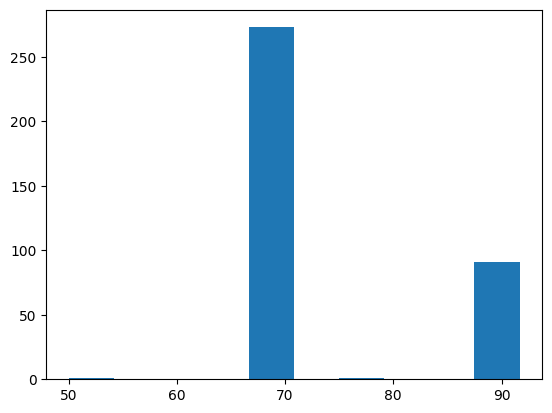

In [15]:
import matplotlib.pyplot as plt
plt.hist(sari_score, bins=10);

In [ ]:
text2text_generator = Text2TextGenerationPipeline(model, tokenizer)
sari_score = []
for idx in range(len(lines_orig)):
    sentence = lines_orig[idx]
    output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
    sari_score.append(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[0][idx]]]))

In [122]:
idx = 10
sentence = lines_orig[idx]
output = text2text_generator(sentence, max_length=128, do_sample=False)[0]['generated_text'].replace(" ","")
print(sentence)
print(output)
print(lines_ref[0][idx])
print(sari.compute(sources=[sentence], predictions=[output], references=[[lines_ref[0][idx]]]))

这位官员说，煤层气是具有很大开发潜力的“绿色能源”，已被列为中国新能源发展战略的重点之一。
煤层气是具有很大开发潜力的“绿色能源”。
这位官员说，煤层气是可以开发的“绿色能源”，是中国重点发展的新能源。
{'sari': 91.66666666666666}
